In [8]:
import logging
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import scipy.stats as stats
import pandas as pd

from dask.distributed import Client, LocalCluster
import dask.delayed

# Dask Cluster

In [3]:
cluster = LocalCluster(
    n_workers=12, 
    threads_per_worker=1, 
    processes=True, 
    silence_logs=logging.ERROR
)
client = Client(cluster)
client

# client.restart()
# client.shutdown()
# client.close()

Client Scheduler: tcp://127.0.0.1:55001 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 34.36 GB


# Statistical Tests

In [120]:
def two_proportions_test(success_a, size_a, success_b, size_b):
    """
    http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions
    
    A/B test for two proportions;
    given a success a trial size of group A and B compute its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
#     print (success_a, size_a, success_b, size_b)
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

# zscore, p_value = two_proportions_test(
#     control_successes, 
#     control_samples,
#     test_successes, 
#     test_samples,
# )

# if p_value <= 0.05:
#     print ("Reject null hypothesis, conversion rates are different")
# else:
#     print ("Accept null hypothesis, samples are NOT different")



In [121]:
def bayesian_rate_comparison(
    control_successes, control_samples, test_successes, test_samples
):

    num_samples = 50000

    control_samples = np.random.beta(
        control_successes, 
        control_samples - control_successes, 
        size=num_samples
    )

    test_samples = np.random.beta(
        test_successes, 
        test_samples - test_successes, 
        size=num_samples
    )

    p_test_gt_control = (test_samples > control_samples).mean()
    p_control_gt_test = (control_samples > test_samples).mean()

    return p_test_gt_control, p_control_gt_test

# p_test_gt_control, p_control_gt_test = bayesian_rate_comparison(
#     control_successes, control_samples, test_successes, test_samples
# )
    
# if p_test_gt_control >= 0.975 or p_control_gt_test >= 0.975:
#     print ("Reject null hypothesis, conversion rates are different")
# else:
#     print ("Accept null hypothesis, samples are NOT different")

In [122]:
def bootstrapped_p_value(
    user_conversion_counts_a, 
    user_session_counts_a,
    user_conversion_counts_b,
    user_session_counts_b,
    results_df
):
    """
    We'll call our difference "tau"
    """
    num_users = results_df.shape[0]
    tau_actual = (
        (user_conversion_counts_b.sum()/user_session_counts_b.sum()) - 
        (user_conversion_counts_a.sum()/user_session_counts_a.sum())
    )
    results = []
    for _ in range(0, 5000):
        # bootstrapped sample
        sample_df = results_df.sample(num_users, replace=True)

        # randomly re-assign groups
        sample_df['assignment'] = np.random.randint(0, 2, size=num_users)

        # calculate observed difference, tau, in the sample
        N_ic = sample_df[sample_df.assignment == 0].total_sessions
        N_it = sample_df[sample_df.assignment == 1].total_sessions
        S_ic = sample_df[sample_df.assignment == 0].total_sessions_converted
        S_it = sample_df[sample_df.assignment == 1].total_sessions_converted
        tau_sample = S_it.sum() / N_it.sum() - S_ic.sum() / N_ic.sum()

        results.append(tau_sample)
    
    # Calculate bootstrapped p-value by comparing actual difference to
    # our bootstrapped distribution of differences under the null hypothesis
    bs_p_value = 1 - (np.abs(tau_actual) >= np.array(results)).sum()/len(results)
    return bs_p_value

# Simulation Function

In [66]:
# dask function itself will run multiple experiments to reduce the number
# of tasks in the graph
def _simulate_experiments(df, randomization_unit, num_experiments=10, test_type='frequentist'):
    output = []
    for x in range(0, num_experiments):
        if randomization_unit == 'user':
            users = df.user.unique()
            users_df = pd.DataFrame({'user': users, 'assignment': np.random.randint(0, 2, size=len(users))})
            df_w_assignments = pd.merge(df, users_df, how='inner', on='user')
        elif randomization_unit == 'session':
            df_w_assignments = df.copy()
            df_w_assignments['assignment'] = np.random.randint(0, 2, size=df.shape[0])
        else:
            raise ValueError("randomization unit must be 'session' or 'user'")

        control_samples = df_w_assignments[df_w_assignments.assignment == 0].session_converted.count()
        control_successes = df_w_assignments[df_w_assignments.assignment == 0].session_converted.sum()

        test_samples = df_w_assignments[df_w_assignments.assignment == 1].session_converted.count()
        test_successes = df_w_assignments[df_w_assignments.assignment == 1].session_converted.sum()
        
        if test_type in ['frequentist_delta', 'bootstrapped']:
            assert randomization_unit == 'user'
            user_grain_results_df = (
                df_w_assignments
                .groupby(['user', 'assignment'])
                .session_converted
                .agg(
                    total_sessions='count',
                    total_sessions_converted='sum'
                )
                .reset_index()
            )
        
        if test_type == 'frequentist':
            zscore, p_value = two_proportions_test(
                control_successes, 
                control_samples,
                test_successes, 
                test_samples,
            )
            output.append(p_value)
        elif test_type == 'frequentist_delta':
            zscore, p_value = two_proportions_test_delta_method(
                user_grain_results_df[user_grain_results_df.assignment == 0].total_sessions_converted,
                user_grain_results_df[user_grain_results_df.assignment == 0].total_sessions, 
                user_grain_results_df[user_grain_results_df.assignment == 1].total_sessions_converted,
                user_grain_results_df[user_grain_results_df.assignment == 1].total_sessions, 
            )
            output.append(p_value)
        elif test_type == 'bootstrapped':
            p_value = bootstrapped_p_value(
                user_grain_results_df[user_grain_results_df.assignment == 0].total_sessions_converted,
                user_grain_results_df[user_grain_results_df.assignment == 0].total_sessions, 
                user_grain_results_df[user_grain_results_df.assignment == 1].total_sessions_converted,
                user_grain_results_df[user_grain_results_df.assignment == 1].total_sessions, 
                user_grain_results_df
            )
            output.append(p_value)
        elif test_type == 'bayesian':
            p_test_gt_control, p_control_gt_test = bayesian_rate_comparison(
                control_successes, control_samples, test_successes, test_samples
            )
            output.append((p_test_gt_control, p_control_gt_test))
        else:
            raise ValueError(
                "test type must be 'frequentist', 'bayesian', 'bootstrapped', or 'frequentist_delta'"
            )
    return output


def simulate_experiments(
    df, 
    num_experiments=10000, 
    num_experiments_per_task=100, 
    randomization_unit='user',
    test_type='frequentist'
):
    
    delayed_output = []
    scattered_df = client.scatter(df)
    for x in range(0, round(num_experiments/num_experiments_per_task)):
        _delayed_output = dask.delayed(_simulate_experiments)(
            scattered_df, 
            randomization_unit, 
            num_experiments_per_task,
            test_type
        )
        delayed_output.append(_delayed_output)
    
    output = dask.compute(*delayed_output)
    return list(itertools.chain.from_iterable(output))

# Simulate A/A Tests

## High sessions per user & large variance in conversion rates

Building dataset
Average sessions per user 9.87



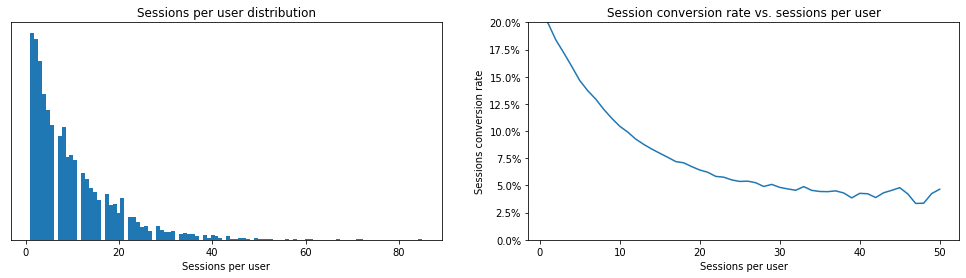

In [7]:
print("Building dataset")
num_users = 5000

sessions_per_user = np.random.geometric(0.1, size=num_users)

avg_conversion_rate = 0.2
rates = avg_conversion_rate*1/5 + avg_conversion_rate*4/5*np.exp(-0.1*(sessions_per_user - 1))

a = rates*1000
b = 1000 - rates*1000
conversion_rates = np.random.beta(a, b, size=num_users);


fig, axs = plt.subplots(1, 2, figsize=(17, 4));

axs[0].set_title('Sessions per user distribution');
axs[0].get_yaxis().set_visible(False);
axs[0].set_xlabel('Sessions per user');
axs[0].hist(sessions_per_user, density=True, bins=100);

df = pd.DataFrame({'spu': sessions_per_user, 'cv': conversion_rates})
gdf = df.groupby('spu').cv.mean().reset_index(name='mean_cv')
axs[1].set_title('Session conversion rate vs. sessions per user');
axs[1].plot(gdf[gdf.spu <= 50].spu, gdf[gdf.spu <= 50].mean_cv);
axs[1].set_xlabel('Sessions per user');
axs[1].set_ylabel('Sessions conversion rate');
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[1].set_ylim(0, 0.2);

data = {
    'user': [],
    'session_id': [],
    'session_converted': []
}

for user_id, num_sessions in enumerate(sessions_per_user):
    conversion_rate = conversion_rates[user_id]
    for session_id in range(1, num_sessions+1):
        session_converted = np.random.choice([0, 1], p=[1-conversion_rate, conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['session_converted'].append(session_converted)

df = pd.DataFrame(data)
print(f"Average sessions per user {sessions_per_user.mean():0.2f}\n")

### Frequentist Test

Running Frequentist tests
Session Level Randomization:
Detected 490 false positives out of 10000 trials (4.90% FPR)
User Level Randomization:
Detected 864 false positives out of 10000 trials (8.64% FPR)


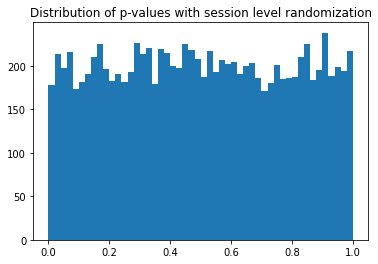

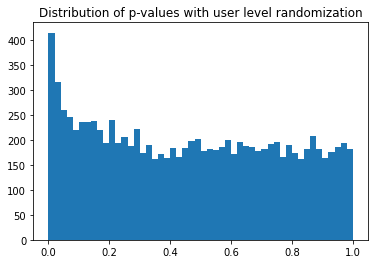

In [40]:
print("Running Frequentist tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    p_values = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250,
        randomization_unit=ru,
        test_type='frequentist'
    )
    
    false_positives = [
        1 for p_value in p_values if p_value <= 0.05
    ]

    print(
        f"Detected {len(false_positives)} false positives out of {len(p_values)} trials"
        f" ({len(false_positives)/len(p_values):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist(p_values, bins=50);
    plt.title(f'Distribution of p-values with {ru} level randomization');

### Bayesian Test

Running Bayesian tests
Session Level Randomization:
Detected 461 false positives out of 10000 trials (4.61% FPR)
User Level Randomization:
Detected 845 false positives out of 10000 trials (8.45% FPR)


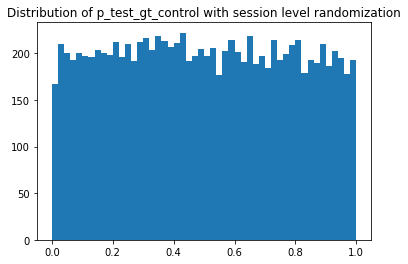

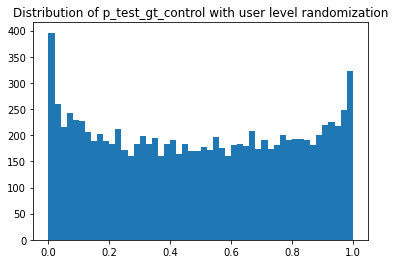

In [41]:
print("Running Bayesian tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    bayesian_probas = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250, 
        randomization_unit=ru,
        test_type='bayesian'
    )
    
    false_positives = [
        1 for p_t, p_c in bayesian_probas if p_t >= 0.975 or p_c >= 0.975
    ]
    
    bayesian_fpr = (
        len(false_positives) 
        / len(bayesian_probas)
    )

    print(
        f"Detected {len(false_positives)} false positives out of {len(bayesian_probas)} trials"
        f" ({len(false_positives)/len(bayesian_probas):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist([p[0] for p in bayesian_probas], bins=50);
    plt.title(f'Distribution of p_test_gt_control with {ru} level randomization');

### Bootstrapped Test

In [47]:
print("Running bootstrapped tests")

p_values = simulate_experiments(
    df, 
#     num_experiments=10000, 
#     num_experiments_per_task=250,
    num_experiments=1000, 
    num_experiments_per_task=25,
    randomization_unit=ru,
    test_type='bootstrapped'
)

false_positives = [
    1 for p_value in p_values if p_value <= 0.05
]

print(
    f"Detected {len(false_positives)} false positives out of {len(p_values)} trials"
    f" ({len(false_positives)/len(p_values):0.2%} FPR)"
)

plt.figure(i);
plt.hist(p_values, bins=50);
plt.title(f'Distribution of p-values with User level randomization');

Running bootstrapped tests


tornado.application - ERROR - Uncaught exception GET /eventstream (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/eventstream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/Users/ianwhitestone/.pyenv/versions/3.7.6/lib/python3.7/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/Users/ianwhitestone/.pyenv/versions/3.7.6/lib/python3.7/site-packages/distributed/http/scheduler/info.py", line 181, in open
    self.plugin.add_worker(self.server, worker)
  File "/Users/ianwhitestone/.pyenv/versions/3.7.6/lib/python3.7/site-packages/distributed/diagnostics/websocket.py", line 17, in add_worker
    self.socket.send("add_worker", {"worker": worker})
  File "/Users/ianwhitestone/.pyenv/versions/3.7.6/lib/python3.7/site-packages/distributed/http/scheduler/info.py", line 177, in send
    self.write_message(data)
  F

ZeroDivisionError: division by zero

## Create Data - high sessions per user & small variance in conversion rates

Building dataset
Average sessions per user 9.86



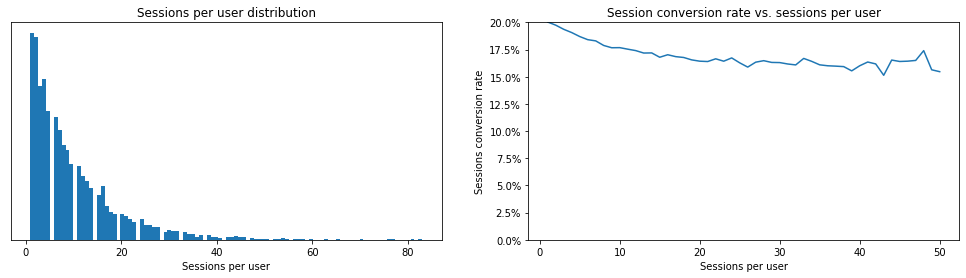

In [9]:
print("Building dataset")
num_users = 5000

sessions_per_user = np.random.geometric(0.1, size=num_users)

avg_conversion_rate = 0.2
rates = avg_conversion_rate*4/5 + avg_conversion_rate*1/5*np.exp(-0.1*(sessions_per_user - 1))

a = rates*1000
b = 1000 - rates*1000
conversion_rates = np.random.beta(a, b, size=num_users);


fig, axs = plt.subplots(1, 2, figsize=(17, 4));

axs[0].set_title('Sessions per user distribution');
axs[0].get_yaxis().set_visible(False);
axs[0].set_xlabel('Sessions per user');
axs[0].hist(sessions_per_user, density=True, bins=100);

df = pd.DataFrame({'spu': sessions_per_user, 'cv': conversion_rates})
gdf = df.groupby('spu').cv.mean().reset_index(name='mean_cv')
axs[1].set_title('Session conversion rate vs. sessions per user');
axs[1].plot(gdf[gdf.spu <= 50].spu, gdf[gdf.spu <= 50].mean_cv);
axs[1].set_xlabel('Sessions per user');
axs[1].set_ylabel('Sessions conversion rate');
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[1].set_ylim(0, 0.2);

data = {
    'user': [],
    'session_id': [],
    'session_converted': []
}

for user_id, num_sessions in enumerate(sessions_per_user):
    conversion_rate = conversion_rates[user_id]
    for session_id in range(1, num_sessions+1):
        session_converted = np.random.choice([0, 1], p=[1-conversion_rate, conversion_rate])
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['session_converted'].append(session_converted)

df = pd.DataFrame(data)
print(f"Average sessions per user {sessions_per_user.mean():0.2f}\n")

## Frequentist Experiments

Running Frequentist tests
Session Level Randomization:
Detected 499 false positives out of 10000 trials (4.99% FPR)
User Level Randomization:
Detected 459 false positives out of 10000 trials (4.59% FPR)


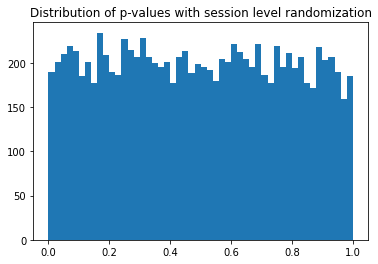

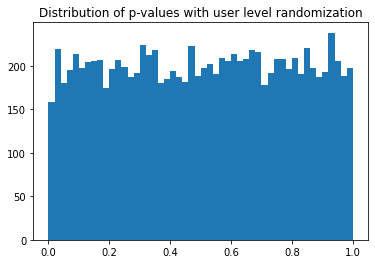

In [26]:
print("Running Frequentist tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    p_values = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250,
        randomization_unit=ru,
        test_type='frequentist'
    )
    
    false_positives = [
        1 for p_value in p_values if p_value <= 0.05
    ]

    print(
        f"Detected {len(false_positives)} false positives out of {len(p_values)} trials"
        f" ({len(false_positives)/len(p_values):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist(p_values, bins=50);
    plt.title(f'Distribution of p-values with {ru} level randomization');

## Bayesian Experiments

Running Bayesian tests
Session Level Randomization:
Detected 488 false positives out of 10000 trials (4.88% FPR)
User Level Randomization:
Detected 455 false positives out of 10000 trials (4.55% FPR)


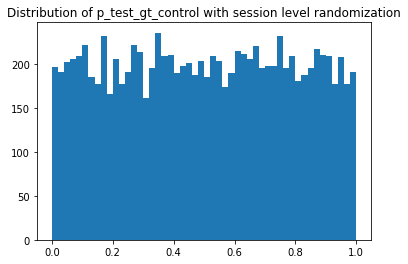

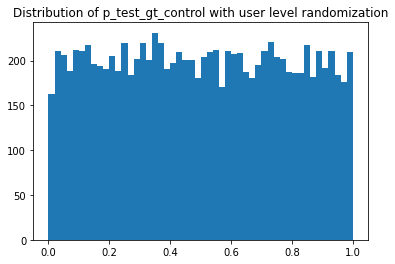

In [27]:
print("Running Bayesian tests")
for i, ru in enumerate(['session', 'user']):
    print(f"{ru.capitalize()} Level Randomization:")
    bayesian_probas = simulate_experiments(
        df, 
        num_experiments=10000, 
        num_experiments_per_task=250, 
        randomization_unit=ru,
        test_type='bayesian'
    )
    
    false_positives = [
        1 for p_t, p_c in bayesian_probas if p_t >= 0.975 or p_c >= 0.975
    ]
    
    bayesian_fpr = (
        len(false_positives) 
        / len(bayesian_probas)
    )

    print(
        f"Detected {len(false_positives)} false positives out of {len(bayesian_probas)} trials"
        f" ({len(false_positives)/len(bayesian_probas):0.2%} FPR)"
    )

    plt.figure(i);
    plt.hist([p[0] for p in bayesian_probas], bins=50);
    plt.title(f'Distribution of p_test_gt_control with {ru} level randomization');